# Use SMOTE with caution

If you are a machine learning practitioner, you may face class imbalance problems more often. Class imbalance happens when there is a different class distribution in the dataset. Let's take an example. Assume we are working on a churn problem. In this specific scenario, our minor and majority classes are customer churn, and the customer stays with the current service provider. But if you explore this problem more, you will notice fewer customers for the churn category because customer churn is an infrequent event that is good for business but not for the model. As a result, if we feed this dataset into the model, it will learn the majority pattern (non-churn scenario) more accurately than the minor scenario. This is where our problem begins.

## How to deal with class imbalance in machine learning?

The most obvious answer is since model interaction with the minor class during training is less, we can improve that by adding more minor classes to the model. But how? We have a few methods,

1. Collecting more data for the minor class — This is a theoretically easy and practically infeasible solution. Because it's hard to do this while covering the business's actual needs, as an example, we may have to change the logic to get more customers into the churn category.
2. Random Oversampling — We can duplicate minor classes till we get a decent class distribution. It may result in the model learning inaccurate churn scenarios. In simple words, it will over-learn little incident patterns.
3. Random Undersampling — We can remove the samples from the majority classes to balance the dataset. However, it will remove some signals from the dataset. Also, if our dataset is highly imbalanced (minor samples are less than 1%), we may have to remove significant majority class samples from our dataset to make it more balanced.
4. We can generate synthetic data — We will focus on this more deeply in this article,

### Generating synthetic data for rebalance the dataset

The basic idea behind this is to generate more minor class samples similar to the existing ones in the minority class. But unlike repeating minor class instances multiple times, this will generate new minor class instances based on the dataset we have. For that SMOTE (Synthetic Minority Oversampling Technique) method is commonly used. But there are many alternatives for that, such as,

ADASYN (Adaptive Synthetic Sampling)
Tomek Links: This technique removes samples from the majority class that are very close to examples in the minority class. The idea is to remove easy cases from the majority class that will likely be misclassified as the minority class.
Near Miss: This technique selects samples from the majority classes closest in feature space to examples in the minority class and removes them from the dataset. The idea is similar to Tomek Links, but instead of eliminating easy cases from the majority class, it removes samples most likely to be misclassified as the minority class.
Let's do some experiments around SMOTE.

First, import the dataset. Here I am using a _**Wine Quality**_, and you can access the dataset using this link. Let's load the dataset and plot the class distribution.

```python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import model_selection

warnings.filterwarnings('ignore')

#reading the dataset
data = np.load('x20data.npz')

df = pd.DataFrame(data['data'])
df['target'] = data['label']
df['target'] = df['target'].replace(-1,0)

df['target']\
.value_counts(normalize=True)\
.plot\
.bar(figsize=(10,6),alpha=0.6)

plt.xlabel("Label")
plt.ylabel("Distribution %")
plt.yticks(list(np.linspace(0,1,11)))
plt.grid(True)
plt.show()

````

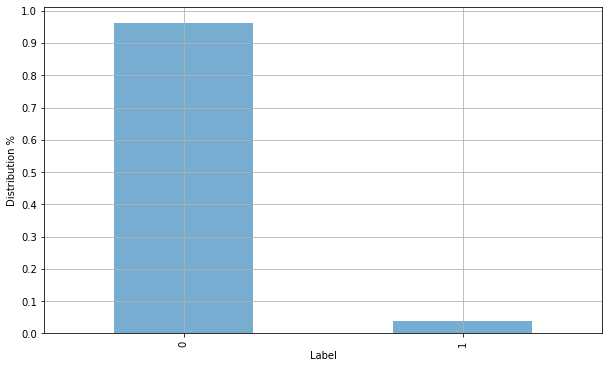

Now we can use the imblearn library to perform SMOTE on our dataset. In the below code, we will do SMOTE on our dataset and plot both the original and resamples versions of the dataset.

```python

#keep holdout dataset for evaluation purpose
df,df_holdout = model_selection.train_test_split(df,stratify=df['target'])

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE

# Set the font family for matplotlib
plt.rcParams['font.family'] = 'Verdana'

# Split your data into features and labels
X = df.drop('target', axis=1)
y = df['target']

# Define the SMOTE resampling method
smote = SMOTE(random_state=42)

# Resample the data using SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Use TSNE for dimensionalilty reduction
X_tsne = TSNE(n_components=2).fit_transform(X)
X_resampled_tsne = TSNE(n_components=2).fit_transform(X_resampled)

# Get the class ratios
original_class_ratio = np.bincount(y) / len(y)
resampled_class_ratio = np.bincount(y_resampled) / len(y_resampled)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data
ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='rainbow',alpha=0.4)
ax1.set_title(f'Original Data\nClass Ratio: {original_class_ratio[1] * 100:.1f} : {original_class_ratio[0] * 100:.1f}')

# Plot the resampled data
ax2.scatter(X_resampled_tsne[:, 0], X_resampled_tsne[:, 1], c=y_resampled, cmap='rainbow',alpha=0.4)
ax2.set_title(f'Resampled Data\nClass Ratio: {resampled_class_ratio[1] * 100:.0f} : {resampled_class_ratio[0] * 100:.0f}')

plt.show()
```

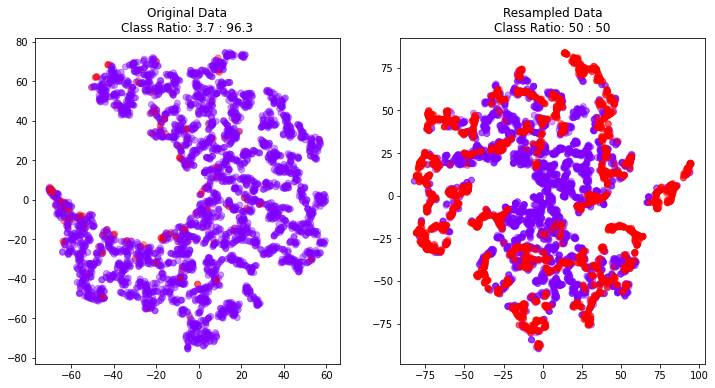

As you can see in the plots, we have converted 220 original minor incidents into 2152, its ~9x increase. That's where the problem lies. Let's focus on our specific churn problem.

1. Generating such fake customer data can lead the model to learn patterns that do not exist in the real world.
2. In most cases, we have quality issues in the dataset. As a result, there is a high chance of adding noises into datasets. Generating new data using noisy data is a bad idea.

With these potential issues, we have the below question in front.

__Are we gonna deploy these models into production?__

If it's a churn or fraud detection problem, I will not deploy it on production. But the answer to the above question highly depends on the data and business problem we are working on. Generally, it's not a good idea to rely on SMOTE when data is noisy, and the problem is complex.

Let's build a classifier using oversampled data and evaluate the model.

```python

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

def plot_confusion_matrix_and_roc(model,df):
    # Make predictions on the holdout set
    
    X,y = df.drop('target',axis=1), df['target']
    
    y_pred = model.predict(X)
    
    # Create the confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Calculate the AUC ROC score
    auc = roc_auc_score(y, y_pred)
    
    # Get the FPR and TPR for the ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the confusion matrix
    ax1.matshow(cm, cmap='Blues')
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
        # Add labels to the confusion matrix
    # for i in range(cm.shape[0]):
    #     for j in range(cm.shape[1]):
    #         ax1.text(j, i, f'{cm[i, j]:n}', ha='center', va='center')
            
    # Add labels for the TP, FP, TN, and FN cells
    ax1.text(0, 0, f'TN: {cm[0, 0]:n}', ha='center', va='center', color='w')
    ax1.text(0, 1, f'FN: {cm[1, 0]:n}', ha='center', va='center', color='k')
    ax1.text(1, 0, f'FP: {cm[0, 1]:n}', ha='center', va='center', color='k')
    ax1.text(1, 1, f'TP: {cm[1, 1]:n}', ha='center', va='center', color='k')
    
    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='AUC ROC = %0.2f' % auc)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.legend()
    
    plt.show()

#let's train the model
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_resampled,y_resampled)

#plot the model performance
plot_confusion_matrix_and_roc(model,df_holdout)
```

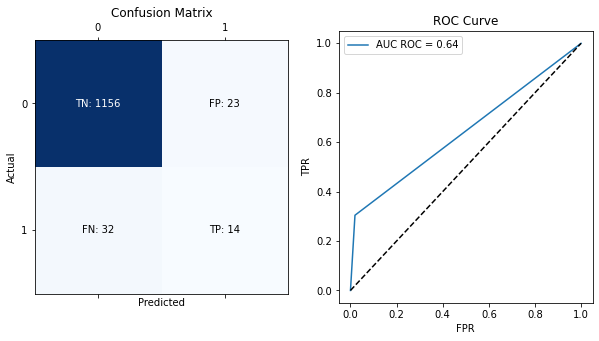

Now it's time to experiment with other approaches for class imbalance. Below I have explained a few methods I have used to tackle imbalance problems.

1. Use class weights
2. Change evaluation metrics
3. Create more features by doing error analysis for the model
4. Use an unsupervised algorithm to detect clusters of the dataset.

Let's dive deep into these methods.

Let's dive deep into these methods.

### _Use class weights_

When training a model on a dataset with class imbalance, the loss function may be dominated by the majority class because it has more instances. It can cause the model to pay more attention to the majority class than the minority class. The main idea of class weights is assigning weights for each sample based on its class. It will give more weight to the minority class during training. Meaning the model will pay more attention to the minority class during training in an effort to improve its performance in that class.

-------------------
_In advance, class weights can be used to balance the loss function by assigning higher weights to the minority class, so that it has a greater impact on the loss function. This can help the model to better learn the characteristics of the minority class and improve its performance on it._

-------------------
Mathematically, class weights are typically incorporated into the loss function by multiplying the loss for each example by the weight for its class. For example, suppose we have a dataset with two classes (0 and 1) and the following class weights:

```python
class_weights = {0: 1, 1: 10}
```

The loss function for a binary classification model might be defined as follows:


$$
\text{loss}(y, y_{pred}) = -(y * \log(y_{pred}) + (1 - y) * \log(1 - y_{pred}))
$$


To incorporate class weights into this loss function, we can modify it as follows:


$$
\text{loss}(y, y_{pred}) = -(y * \text{class_weights}[1] * \log(y_{pred}) + (1 - y) * \text{class_weights}[0] * \log(1 - y_{pred}))
$$

Now, when the model is trained, the loss for each example will be multiplied by the class weight for its class. It will cause the model to pay more attention to the minority class since its samples will significantly impact the loss function.

In most major machine learning model accept sample_weight parameter. Here is an example how you can do this with XGBoost library.

``` python
# this will compute sample weight for us
from sklearn.utils import compute_sample_weight

#coputing class weights, this will be (num_samples_in_y,)
sample_weights = compute_sample_weight(class_weight='balanced',y=y)

model = XGBClassifier()

# just plug sample weight parameter into your model
model.fit(X,y,sample_weight=sample_weights)
```

One thing to notice here is that sample weights can potentially lead to overfitting if the weights are too high. It's generally a good idea to try a range of weights and see which gives the best performance on the validation set.

Alternatively, we can use the scale_pos_weight parameter in XGBoost as well. It will give you similar results.

Let's quickly plot the above model performance.

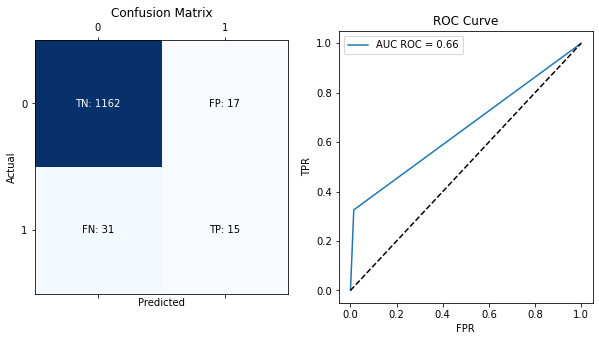

If you check the confusion matrix for the above two scenarios. In that case, you will notice high false positives in the oversampled scenario. We have fewer false positive predictions using class weights. It also reduced our true positives as well. So we have to tweak our approaches based on real business needs.

### _Change evaluation metrics_

Most libraries use Accuracy as the default evaluation metric for classification tasks. It's okay for balanced problems. But imbalanced problems will lead the model to guess the majority class without learning any potential signals.

For example, say we have 97 non-churn customers and 3 churn customers. If we are building a model used accuracy as an evaluation metric, it can achieve 97% accuracy by blindly predicting non-churn class for every 100 samples. As an easy fix, we can change the evaluation metric into something different. Precision, Recall, F1 Score, and Balanced Accuracy are a few best options for the imbalance classification task.

### _Create more features by doing error analysis for the model_

When your model performs poorly, we can use error analysis to find different data segments with varying performance levels. Let's take the previous churn example; we can find the model's error vs. customers' revenue bucket and identify revenue segments where the model is good and evil. Likewise, we can create an error analysis report with this information. After the error analysis report, we can determine possible new features which the model can use to distinguish the churner vs. the non-churner scenarios.

For example, if you know low revenue users are churning because of the "XYZ" reason, you can add that feature if it's not already in the model. Otherwise, you can perform feature engineering methods with that potential feature, such as binning the "XYZ" feature.

### _Use unsupervised algorithm to detect clusters of the dataset_

One of the powerful and popular approaches is segmentation. If we know some features that can be used for segregating data into different subgroups, we can use those features for the clustering model. After clustering, you will note various class imbalances in other groups. There are a few possible scenarios. Such as,

1. You may find subgroups only with one class. After verifying this customer behavior, we can further skip modeling for this particular subgroup. It will reduce the imbalance of the whole dataset.
2. You may find a somewhat balanced distribution that is easy to model compared to the previous dataset.
3. Or, you may find subgroups with a highly imbalanced class distribution. But this is not lousy compared to the original distribution. The reason for this is this imbalance occurs in similar data points and can be a strong signal even though the distribution is imbalanced. For example, if we are working on a disease prediction model, it's a good idea to group people into subgroups based on age. If the general class imbalance is 2%, grouping on age will produce different class distributions for different subgroups. In the higher age group, this will be more balanced. In the middle and young age groups, this will be highly imbalanced. Since we are modeling each segment separately, the model can generalize to that particular segment well.

------------

## Conclusion

This article aims to show alternatives to treat class imbalance other than synthetic data generation. It's worth noting that some methods heavily depend on the data, problem type, and domain you are working on. It's always a good idea to experiment with a few different approaches and pick the best one for your problem.

Please find the citation for the above dataset.

_Lemaitre, G., Nogueira, F., Aridas, C. K., & Oliveira, D. V. R. (2016). Imbalanced dataset for benchmarking [Data set]. Zenodo. https://doi.org/10.5281/zenodo.61452__

Thanks for reading.